## Logisitic Regression
First we need to load in the data and split it into train and test sets. It looks like each subject has slightly different synset "classes" so I'm going to start off doing regression for each subject individually, then if we want we can do some fancy data cleaning stuff to do regression on all of them at once.

In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc

from utils import load_data


In [93]:
masks, data = load_data(1)
print(masks.shape, data.shape)

(4039, 43) (235, 4039)


We are going to start by splitting the data. Our masks are unaffected by this split so we want to do this first before we try accessing anything with the masks.

In [97]:
train_data, test_data = train_test_split(data, test_size=0.2)
print(train_data.shape, test_data.shape)

(188, 4039) (47, 4039)


In [98]:
def trim_front_back(instring, fstring, bstring):
    """Helper function to format class labels"""
    fpos = instring.find(fstring) + len(fstring)
    bpos = instring.find(bstring)
    return instring[fpos:bpos]

teststring = "Synset_writing_ID_06362953"
print(trim_front_back(teststring, "Synset_", "_ID"))

writing


Each mask provides the location of the corresponding class label within the data. We want to get these values as an array in the shape `[observations, labels]`. Since the masks all refer to a unique index we can just combine them into a single mask indicating the position of each element. (Kinda a janky version of [one-hot encoding](https://www.kaggle.com/code/dansbecker/using-categorical-data-with-one-hot-encoding/notebook))

In [103]:
def encode_labels(masks):
    label_columns_mask = ["Synset" in colname for colname in masks.columns]
    label_colnames = masks.columns[label_columns_mask]
    label_names = [trim_front_back(name, "Synset_", "_ID") for name in label_colnames]
    label_indices = np.stack([masks[name].to_numpy().nonzero() for name in label_colnames]).squeeze()
    return label_names, label_indices

label_names, label_indices = encode_labels(masks)
print(label_names, label_indices)

['building', 'chair', 'character', 'clothing', 'code', 'cognition', 'external_body_part', 'geographical_area', 'girl', 'group', 'illustration', 'implement', 'line', 'male', 'material', 'natural_object', 'performer', 'picture', 'room', 'shape', 'table', 'vertebrate', 'way', 'window', 'workplace', 'writing'] [4016 4018 4011 4017 4030 4027 4014 4034 4025 4028 4033 4022 4032 4010
 4026 4015 4035 4019 4012 4020 4029 4021 4023 4024 4013 4031]


We can now use `label_indices` to access the data and get the one-hot encodings. I do this as an example below, but ideally we do this after we split our data.

In [104]:
def get_onehot_labels_df(data, label_indices, label_names):
    label_data = data[:, label_indices]
    label_df = pd.DataFrame(label_data, columns = label_names)
    return label_df

get_onehot_labels_df(train_data, label_indices, label_names).shape

(188, 26)

`label_df` is now a dataframe where the rows correspond to entries in the data and the columns correspond to whether or not a particular class appeared within the subject's dream for that entry. 

We can also choose to combine feature areas later if we want, but for now we will keep each feature area as an individual mask and define a function to get a particular set of features.

In [105]:
masks.columns[~np.array(label_columns_mask)]

Index(['EEG_sleep_score', 'FFA', 'HVC', 'LOC', 'LVC', 'PPA', 'V1', 'V2', 'V3',
       'X', 'Y', 'Z', 'design', 'label', 'sample_number', 'session_number',
       'voxelData'],
      dtype='object')

In [90]:
feature_names = ["FFA", "HVC", "LOC", "LVC", "PPA", "V1", "V2", "V3"]
feature_df = masks[feature_names]
feature_df.head()

,FFA,HVC,LOC,LVC,PPA,V1,V2,V3
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [107]:
def get_features_arr(data, feature_df, feature):
    feature_mask = feature_df[feature].to_numpy().astype(bool)
    feature_data = data[:, feature_mask]
    return feature_data

get_features_arr(train_data, feature_df, "FFA").shape

(188, 537)

Now we can do our logistic regression

In [159]:
def plot_pr_curve(model, testx, testy):
    pos_probas = model.predict_proba(testx)[:, 1]
    precision, recall, thresh = precision_recall_curve(testy, pos_probas)
    ap = auc(recall, precision)
    print(f"average precision: {ap}")

    plt.figure()
    plt.plot(recall, precision)
    plt.xlabel("recall")
    plt.ylabel("precision")

In [165]:
print(label_names)
print(feature_names)

['building', 'chair', 'character', 'clothing', 'code', 'cognition', 'external_body_part', 'geographical_area', 'girl', 'group', 'illustration', 'implement', 'line', 'male', 'material', 'natural_object', 'performer', 'picture', 'room', 'shape', 'table', 'vertebrate', 'way', 'window', 'workplace', 'writing']
['FFA', 'HVC', 'LOC', 'LVC', 'PPA', 'V1', 'V2', 'V3']


running for class:girl...
average precision: 0.14302849927849925
running for class:character...
average precision: 0.18363912769565754
running for class:building...
average precision: 0.05134019124891336


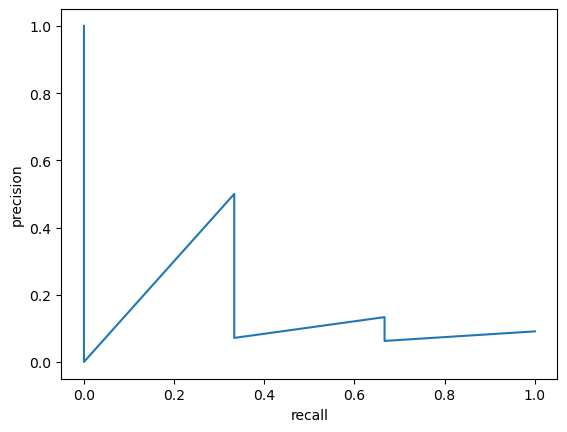

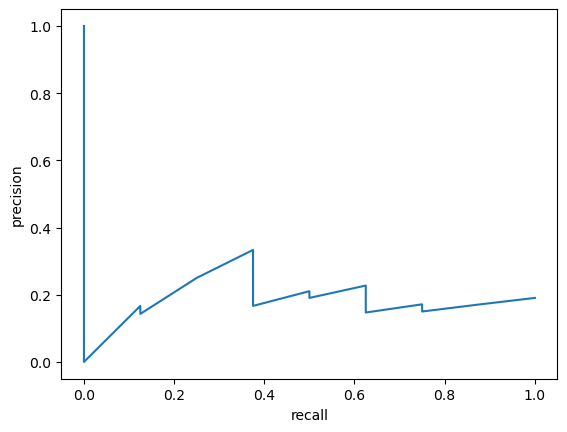

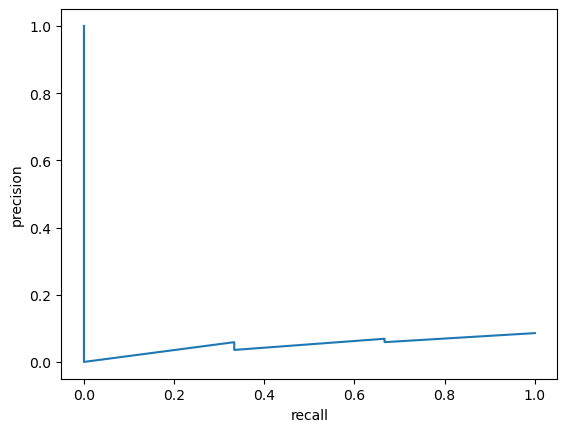

In [167]:
def run_model(class_name, feature_name):
    print(f"running for class:{class_name}...")
    class_idx = label_names.index(class_name)

    trainy = get_onehot_labels_df(train_data, label_indices, label_names).to_numpy()[:, class_idx]
    trainx = get_features_arr(train_data, feature_df, feature_name)
    testy = get_onehot_labels_df(test_data, label_indices, label_names).to_numpy()[:, class_idx]
    testx = get_features_arr(test_data, feature_df, feature_name)


    model = LogisticRegression(solver="lbfgs", max_iter=1000).fit(trainx, trainy)

    plot_pr_curve(model, testx, testy)

run_model("girl", "FFA")
run_model("character", "FFA")
run_model("building", "FFA")

This gives some really interesting results! The FFA is good the facial detection area, and you can tell! We get an average precision of 0.14 for "girl" class and 0.18 for "character". Neither of these are particularly good, but they're much higher than the other classes like "building" which has an ap of 0.05